# **Downloading the Dataset**

In [3]:
# Install Kaggle library
!pip install -q kaggle

# Upload Kaggle API key (kaggle.json)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"my_username","key":"my_key"}'}

In [4]:
# Create directory for the Kaggle API key
!mkdir -p ~/.kaggle

# Copy the Kaggle API key to the appropriate directory
!cp kaggle.json ~/.kaggle

# Set appropriate permissions for the Kaggle API key
!chmod 600 ~/.kaggle/kaggle.json

# Download the DermNet dataset using the Kaggle API
!kaggle datasets download -d 'nirmalsankalana/rice-leaf-disease-image'

Dataset URL: https://www.kaggle.com/datasets/nirmalsankalana/rice-leaf-disease-image
License(s): CC0-1.0
rice-leaf-disease-image.zip: Skipping, found more recently modified local copy (use --force to force download)


# **Data Extraction**

In [5]:
# Import the necessary library for handling zip files
import zipfile

# Specify the name of the downloaded dataset zip file
dataset_zip = zipfile.ZipFile('rice-leaf-disease-image.zip', 'r')

# Extract the contents of the zip file to the specified directory
dataset_zip.extractall('rice-leaf-disease-image')

# Close the zip file after extraction
dataset_zip.close()

# **Dataset Examination**

In [6]:
import os
import matplotlib.pyplot as plt

# Set the path to the dataset directory
dataset_dir = 'rice-leaf-disease-image'

# Get the list of class names (assuming each subdirectory represents a class)
class_names = sorted(os.listdir(dataset_dir))

# Initialize lists to store the number of images for each class
data_counts = []

# Iterate over each class
for class_name in class_names:
    # Count the number of images in the train directory for the current class
    class_dir = os.path.join(dataset_dir, class_name)
    data_count = len(os.listdir(class_dir))
    data_counts.append(data_count)

# Print the total images for each class with the class name
for class_name, count in zip(class_names, data_counts):
    print(f"{class_name}: {count} images")

Bacterialblight: 1584 images
Blast: 1440 images
Brownspot: 1600 images
Tungro: 1308 images


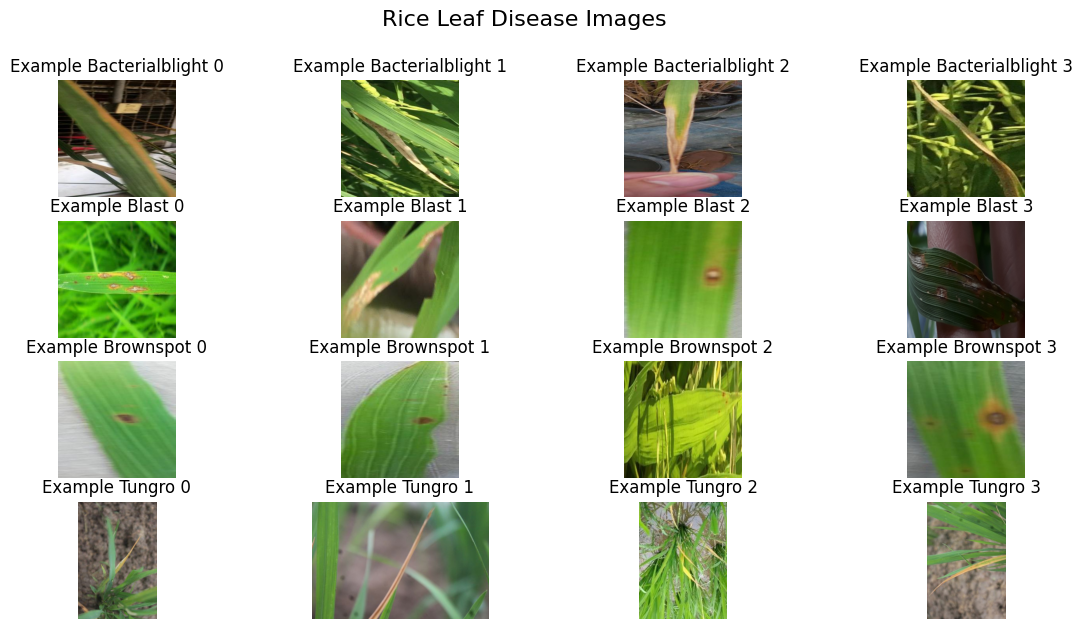

In [7]:
import tensorflow as tf

# Get the filenames for disease images
Bacterialblight_filenames = [os.path.join(dataset_dir, 'Bacterialblight',filename) for filename in os.listdir(os.path.join(dataset_dir, 'Bacterialblight'))]
Blast_filenames = [os.path.join(dataset_dir, 'Blast',filename) for filename in os.listdir(os.path.join(dataset_dir, 'Blast'))]
Brownspot_filenames = [os.path.join(dataset_dir, 'Brownspot',filename) for filename in os.listdir(os.path.join(dataset_dir, 'Brownspot'))]
Tungro_filenames = [os.path.join(dataset_dir, 'Tungro',filename) for filename in os.listdir(os.path.join(dataset_dir, 'Tungro'))]

fig, axes = plt.subplots(4, 4, figsize=(14, 7))
fig.suptitle('Rice Leaf Disease Images', fontsize=16)

# Plot the first 4 images of each class
for i, Bacterialblight_image in enumerate(Bacterialblight_filenames[:4]):
    img = tf.keras.utils.load_img(Bacterialblight_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Bacterialblight {i}')
    axes[0, i].axis('off')  # Hide axes

for i, Blast_image in enumerate(Blast_filenames[:4]):
    img = tf.keras.utils.load_img(Blast_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Blast {i}')
    axes[1, i].axis('off')  # Hide axes

for i, Brownspot_image in enumerate(Brownspot_filenames[:4]):
    img = tf.keras.utils.load_img(Brownspot_image)
    axes[2, i].imshow(img)
    axes[2, i].set_title(f'Example Brownspot {i}')
    axes[2, i].axis('off')  # Hide axes

for i, Tungro_image in enumerate(Tungro_filenames[:4]):
    img = tf.keras.utils.load_img(Tungro_image)
    axes[3, i].imshow(img)
    axes[3, i].set_title(f'Example Tungro {i}')
    axes[3, i].axis('off')  # Hide axes


plt.show()

# **Splitting Data**

In [8]:
import os
import shutil

dataset_dir = 'rice-leaf-disease-image'
classdir_name = os.listdir(dataset_dir)

training_percentage = 0.75
validation_percentage = 0.15
test_percentage = 0.15

training_dataset_dir = 'split_datset/train'
validation_dataset_dir = 'split_datset/validation'
test_dataset_dir = 'split_datset/test'

os.makedirs(training_dataset_dir, exist_ok=True)
os.makedirs(validation_dataset_dir, exist_ok=True)
os.makedirs(test_dataset_dir, exist_ok=True)

for class_name in classdir_name :
  class_path = os.path.join(dataset_dir, class_name)      #Path dari kelas yang sedang diakses

  count = 0
  training_length = int(len(os.listdir(class_path)) * training_percentage)
  validation_length = int(len(os.listdir(class_path)) * validation_percentage)
  test_length = int(len(os.listdir(class_path)) * test_percentage)

  training_classpath = os.path.join(training_dataset_dir, class_name)
  validation_classpath = os.path.join(validation_dataset_dir, class_name)
  test_classpath = os.path.join(test_dataset_dir, class_name)

  os.makedirs(training_classpath, exist_ok=True)
  os.makedirs(validation_classpath, exist_ok=True)
  os.makedirs(test_classpath, exist_ok=True)

  for filename in os.listdir(class_path):
    source_path = os.path.join(class_path, filename)
    if count < training_length:
      shutil.copy(source_path, training_classpath)
    elif count < training_length + validation_length:
      shutil.copy(source_path, validation_classpath)
    else:
      shutil.copy(source_path, test_classpath)
    count += 1

# **Data Augmentation**

In [9]:
# Variabel Konfigurasi Global

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
LABEL_MODE='categorical'

SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

EPOCHS = 35

In [10]:
import tensorflow as tf

def create_augmentation_model():
    """Creates a model (layers stacked on top of each other) for augmenting images of Bacterialblight, Blast, and Brownspot.

    Returns:
        tf.keras.Model: The model made up of the layers that will be used to augment the images of Bacterialblight, Blast, and Brownspot.
    """

    augmentation_model = tf.keras.Sequential([
		    # Specify the input shape.
        tf.keras.Input(shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3)),
        # Add the augmentation layers
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.4, fill_mode='nearest'),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode='reflect'),
        tf.keras.layers.RandomZoom(0.2, fill_mode='nearest'),

    ])

    return augmentation_model

In [11]:
# Instantiate the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    training_dataset_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

# Instantiate the validation set
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dataset_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )
# Instantiate the validation set
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dataset_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

# Normalisasi dataset dengan Rescaling layer
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Optimize the datasets for training
train_dataset_final = (train_dataset
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

test_dataset_final = (test_dataset
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                      )

Found 4449 files belonging to 4 classes.
Found 889 files belonging to 4 classes.
Found 594 files belonging to 4 classes.


# **Model Building and Architecture Configuration**

In [12]:
from tensorflow.keras import regularizers

# Define the CNN model architecture
def create_model():
    """Creates the untrained model for classifying Bacterialblight, Blast, and Brownspot.

    Returns:
        tf.keras.Model: The model that will be trained to classify Bacterialblight, Blast, and Brownspot.
    """
    #Get the augmentation layers (or model) from your earlier function
    augmentation_layers = create_augmentation_model()

    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        # Add the augmentation layers directly
        augmentation_layers,
        # Convolution and Pooling layers
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),

        # Output layer with 4 neurons, according to the number of classes
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy',
              optimizer = tf.optimizers.Adam(learning_rate=1e-4),
              metrics = ['accuracy'])
    return model

In [13]:
model = create_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,680,580 (36.93 MB)

 Trainable params: 9,680,580 (36.93 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Check Data Shape, Get one batch of data from train_dataset_final
for example_batch_images, example_batch_labels in train_dataset_final.take(1):
    print("Shape of example_batch_images:", example_batch_images.shape)
    print("Shape of example_batch_labels:", example_batch_labels.shape)


Shape of example_batch_images: (32, 224, 224, 3)
Shape of example_batch_labels: (32, 4)


In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    train_dataset_final,
    validation_data=validation_dataset_final,
    epochs=EPOCHS,
    verbose=2,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/35
140/140 - 17s - 121ms/step - accuracy: 0.5738 - loss: 1.0004 - val_accuracy: 0.7300 - val_loss: 0.7970 - learning_rate: 1.0000e-04
Epoch 2/35
140/140 - 15s - 104ms/step - accuracy: 0.7393 - loss: 0.7066 - val_accuracy: 0.7064 - val_loss: 0.7804 - learning_rate: 1.0000e-04
Epoch 3/35
140/140 - 9s - 63ms/step - accuracy: 0.7997 - loss: 0.5537 - val_accuracy: 0.7435 - val_loss: 0.6528 - learning_rate: 1.0000e-04
Epoch 4/35
140/140 - 10s - 74ms/step - accuracy: 0.8364 - loss: 0.4465 - val_accuracy: 0.7840 - val_loss: 0.4933 - learning_rate: 1.0000e-04
Epoch 5/35
140/140 - 9s - 64ms/step - accuracy: 0.8413 - loss: 0.4034 - val_accuracy: 0.7840 - val_loss: 0.5131 - learning_rate: 1.0000e-04
Epoch 6/35
140/140 - 9s - 65ms/step - accuracy: 0.8600 - loss: 0.3477 - val_accuracy: 0.8673 - val_loss: 0.3591 - learning_rate: 1.0000e-04
Epoch 7/35
140/140 - 9s - 64ms/step - accuracy: 0.8811 - loss: 0.3014 - val_accuracy: 0.8133 - val_loss: 0.4250 - learning_rate: 1.0000e-04
Epoch 8/35
140/

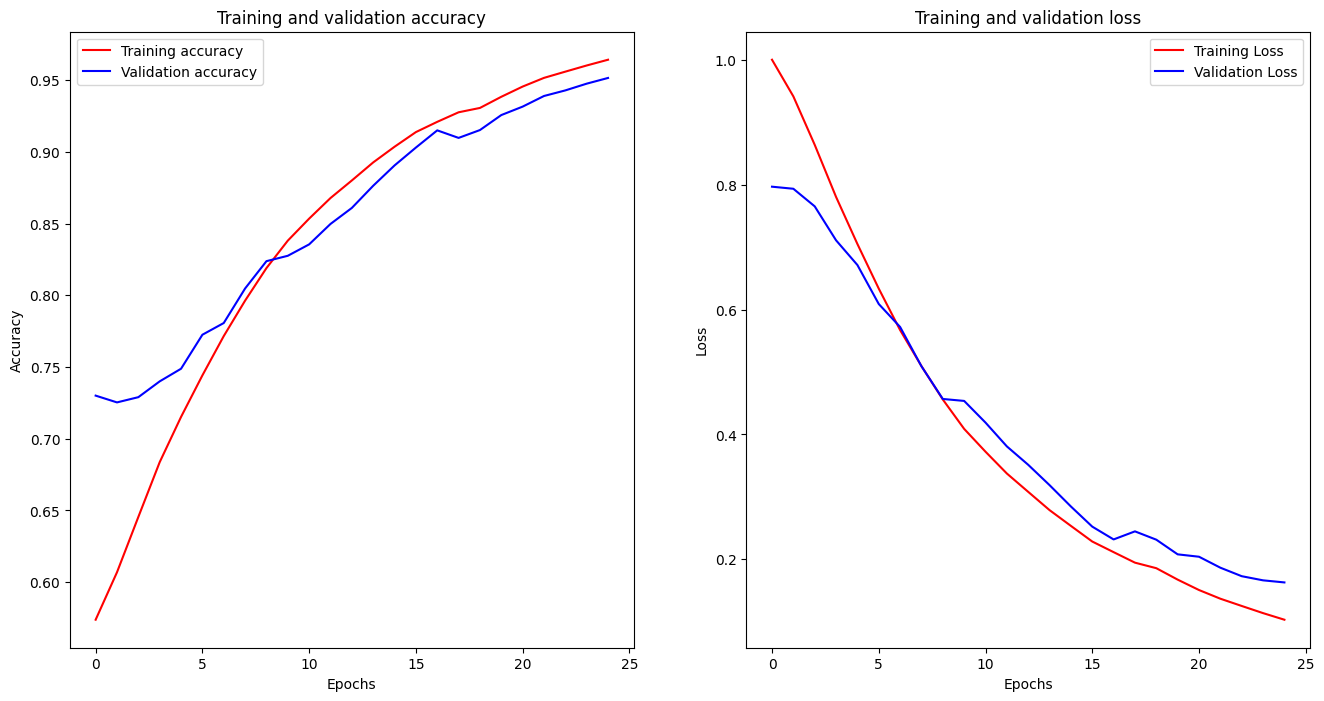

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Function to smooth curves
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Apply smoothing to accuracy and loss values
acc = smooth_curve(history.history['accuracy'])
val_acc = smooth_curve(history.history.get('val_accuracy', []))
loss = smooth_curve(history.history['loss'])
val_loss = smooth_curve(history.history.get('val_loss', []))

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot smoothed accuracy
ax[0].plot(epochs, acc, 'r', label='Training accuracy', antialiased=True)
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy', antialiased=True)
ax[0].set_title('Training and validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot smoothed loss
ax[1].plot(epochs, loss, 'r', label='Training Loss', antialiased=True)
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss', antialiased=True)
ax[1].set_title('Training and validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Generate prediction on the test set
predictions = model.predict(test_dataset_final)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = np.argmax(np.concatenate([y.numpy() for x, y in test_dataset_final], axis=0), axis=1)
class_names = ["Bacterialblight", "Blast", "Brownspot", "Tungro"]

# Classification Report with class name
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion Matrix with class name
conf_matrix = confusion_matrix(true_classes, predicted_classes)
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

print("\nConfusion Matrix:")
print(conf_matrix_df)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       1.00      1.00      1.00       159
          Blast       1.00      0.94      0.97       144
      Brownspot       0.96      0.99      0.97       160
         Tungro       0.98      1.00      0.99       131

       accuracy                           0.98       594
      macro avg       0.98      0.98      0.98       594
   weighted avg       0.98      0.98      0.98       594


Confusion Matrix:
                 Bacterialblight  Blast  Brownspot  Tungro
Bacterialblight              159      0          0       0
Blast                          0    136          7       1
Brownspot                      0      0        158       2
Tungro                         0      0          0     131


In [18]:
y_pred = np.argmax(predictions, axis=1)
#y_true = np.argmax(np.concatenate([y.numpy() for x, y in test_dataset_final], axis=0), axis=1)
y_pred

array([0, 0, 1, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 3, 0, 2, 2, 0, 0, 0, 1,
       1, 1, 2, 2, 1, 0, 0, 2, 3, 1, 2, 2, 3, 2, 1, 2, 3, 3, 2, 1, 0, 0,
       0, 2, 3, 0, 2, 1, 2, 2, 3, 3, 3, 1, 1, 3, 2, 2, 2, 3, 3, 1, 3, 3,
       3, 3, 1, 0, 2, 1, 2, 1, 3, 0, 1, 0, 1, 2, 1, 3, 1, 3, 2, 2, 1, 1,
       2, 3, 1, 1, 0, 1, 1, 1, 2, 1, 3, 2, 0, 0, 1, 2, 1, 2, 1, 0, 2, 3,
       0, 2, 0, 0, 3, 0, 0, 1, 3, 2, 1, 1, 0, 3, 2, 2, 0, 0, 0, 2, 3, 3,
       2, 0, 1, 3, 1, 3, 2, 0, 0, 3, 0, 2, 0, 1, 0, 3, 0, 3, 2, 3, 0, 1,
       0, 0, 2, 2, 0, 2, 2, 1, 1, 0, 2, 3, 3, 1, 1, 2, 0, 0, 1, 3, 0, 0,
       3, 1, 1, 3, 3, 3, 2, 3, 1, 0, 3, 2, 1, 3, 0, 3, 1, 3, 0, 3, 2, 2,
       0, 2, 3, 0, 0, 3, 2, 1, 0, 2, 0, 3, 1, 0, 1, 2, 0, 2, 3, 2, 3, 3,
       1, 3, 2, 3, 1, 0, 0, 0, 1, 3, 0, 2, 3, 2, 0, 2, 1, 0, 0, 3, 1, 0,
       1, 2, 2, 3, 2, 3, 2, 2, 2, 0, 3, 0, 3, 1, 0, 0, 0, 3, 2, 1, 0, 1,
       3, 0, 0, 0, 2, 1, 2, 3, 1, 2, 1, 3, 1, 1, 1, 2, 1, 0, 3, 3, 1, 1,
       3, 0, 3, 3, 2, 1, 2, 0, 2, 3, 3, 2, 2, 0, 2,

Saving TES MODEL.jpg to TES MODEL.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Bacterialblight
[[5.5781370e-01 2.7859144e-02 6.3466757e-08 4.1432703e-01]]


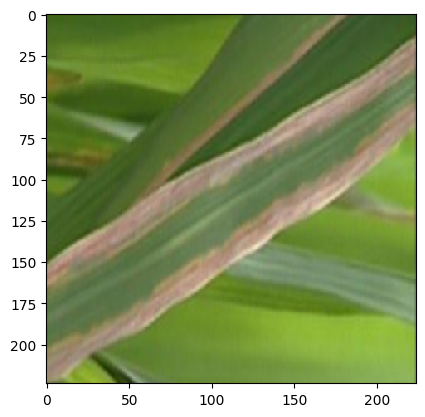

In [20]:
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
    # Load and preprocess the image
    img_path = fn
    img = image.load_img(img_path, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)

    x = x/255
    x = np.expand_dims(x, axis=0)

    preds = model.predict(x)
    classes = np.argmax(preds, axis=1)

    if classes == 0:
        print("Bacterialblight")
    elif classes == 1:
        print("Blast")
    elif classes == 2:
        print("Brownspot")
    elif classes == 3:
        print("Tungro")
    else:
        print("Tanamanmu sehat")

    print(preds)
